In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Secluding 'X_train' according to 'target_train'

In [28]:
#Loading data
data = pd.read_csv('data.csv')
target_train = pd.read_csv('target_train.csv')

#Secluding
X_train = data[data['id'].isin(target_train['id'])]
X_train.to_csv('X_train.csv', index=False)

# Checking if ID's match
unames_X_train = X_train['id'].unique()
unames_target_train = target_train['id'].unique()
set(unames_X_train) == set(unames_target_train)

True

Visualize just to have a look

Text(0.5, 1.0, 'Axis [1, 1]')

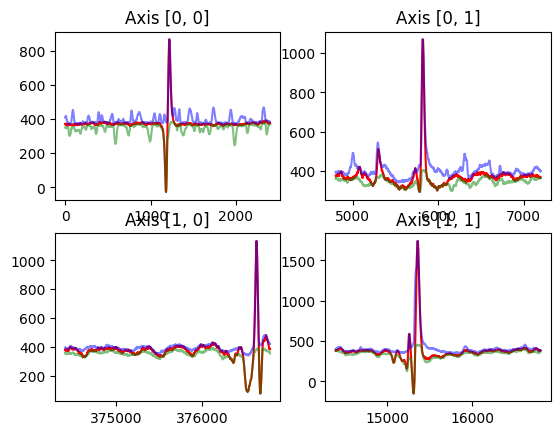

In [68]:
ID = ['1_1','4_1','6_2','8_1']
sample1 = X_train[X_train['id']==ID[0]]
sample2 = X_train[X_train['id']==ID[1]]
sample3 = X_train[X_train['id']==ID[2]]
sample4 = X_train[X_train['id']==ID[3]]

fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(sample1['ch0'], c='r', label='ch0')
axs[0, 0].plot(sample1['ch1'], c='g', alpha=0.5, label='ch1')
axs[0, 0].plot(sample1['ch2'], c='b', alpha=0.5, label='ch1') 
axs[0, 0].set_title('Axis [0, 0]')

axs[0, 1].plot(sample2['ch0'], c='r', label='ch0')
axs[0, 1].plot(sample2['ch1'], c='g', alpha=0.5, label='ch1')
axs[0, 1].plot(sample2['ch2'], c='b', alpha=0.5, label='ch1') 
axs[0, 1].set_title('Axis [0, 1]')

axs[1, 0].plot(sample3['ch0'], c='r', label='ch0')
axs[1, 0].plot(sample3['ch1'], c='g', alpha=0.5, label='ch1')
axs[1, 0].plot(sample3['ch2'], c='b', alpha=0.5, label='ch1') 
axs[1, 0].set_title('Axis [1, 0]')

axs[1, 1].plot(sample4['ch0'], c='r', label='ch0')
axs[1, 1].plot(sample4['ch1'], c='g', alpha=0.5, label='ch1')
axs[1, 1].plot(sample4['ch2'], c='b', alpha=0.5, label='ch1') 
axs[1, 1].set_title('Axis [1, 1]')